<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LGBM" data-toc-modified-id="LGBM-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#DecisionTree" data-toc-modified-id="DecisionTree-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DecisionTree</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Проверка на адекватность</a></span><ul class="toc-item"><li><span><a href="#Предсказание-константного-значения-=-150" data-toc-modified-id="Предсказание-константного-значения-=-150-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Предсказание константного значения = 150</a></span></li><li><span><a href="#Предсказание-среднего-значения-тренировочной-выборки" data-toc-modified-id="Предсказание-среднего-значения-тренировочной-выборки-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Предсказание среднего значения тренировочной выборки</a></span></li></ul></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Цель:** построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [1]:
import pandas as pd 
import numpy as np 
import lightgbm as lgb
import warnings
import time 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("D:/Users/Egor/Desktop/Proga/Jupyter/taxis/taxi.csv", index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.isna().sum()

num_orders    0
dtype: int64

In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


**Вывод:**
- Данные загружены с индексом времени и отсортированы по данному индексу;
- Пропущенных значений нет;
- Среднее количество заказов ~ 14, максимальное равно 119.

## Анализ

In [6]:
print('Начало отсчета времени:', data.index.min())
print('Конец отсчета:', data.index.max())
print('Общее время:', data.index.max() - data.index.min())

Начало отсчета времени: 2018-03-01 00:00:00
Конец отсчета: 2018-08-31 23:50:00
Общее время: 183 days 23:50:00


In [7]:
data = data.resample('1H').sum()

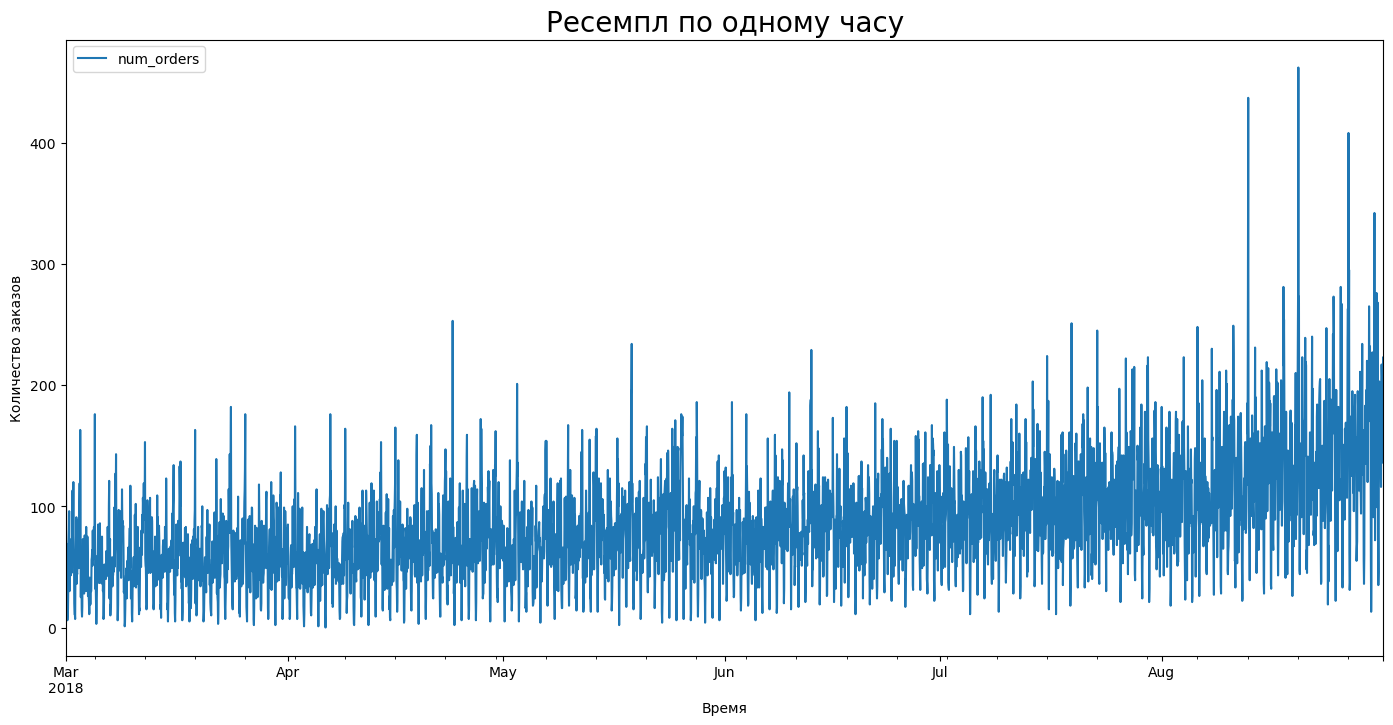

In [8]:
plt.figure(figsize=(17, 8))
data.plot(ax=plt.gca())
plt.xlabel('Время', size=10)
plt.ylabel('Количество заказов', size=10)
plt.title('Pесемпл по одному часу', size=20)
plt.show()

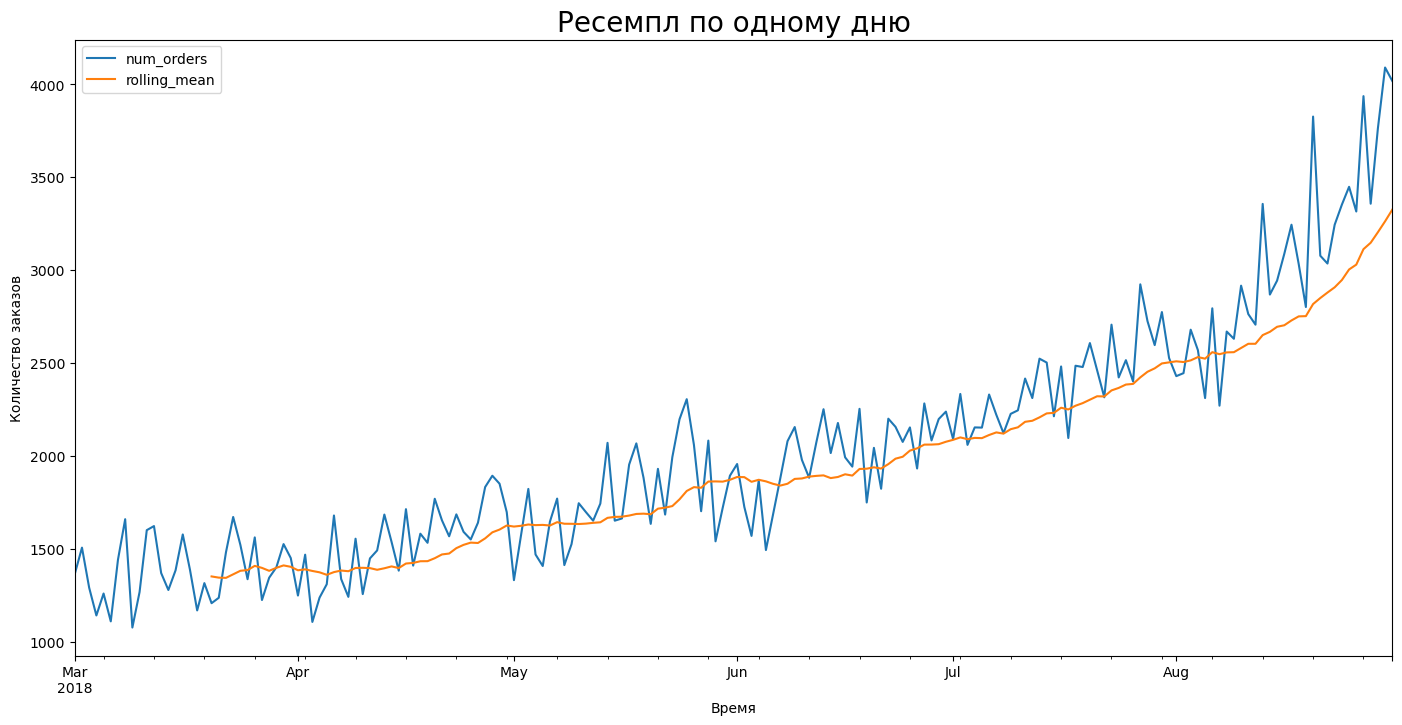

In [9]:
data_1D = data.resample('1D').sum()
data_1D['rolling_mean'] = data_1D.rolling(20).mean() 

plt.figure(figsize=(17, 8))
data_1D.plot(ax=plt.gca())
plt.xlabel('Время', size=10)
plt.ylabel('Количество заказов', size=10)
plt.title('Pесемпл по одному дню', size=20)
plt.show()

**Вывод:**
- При ресемплировании по одному дню, видно, что присутствует положительная динамика в количестве заказов такси. С начала и до конца периода преобладает рост в этом показателе.

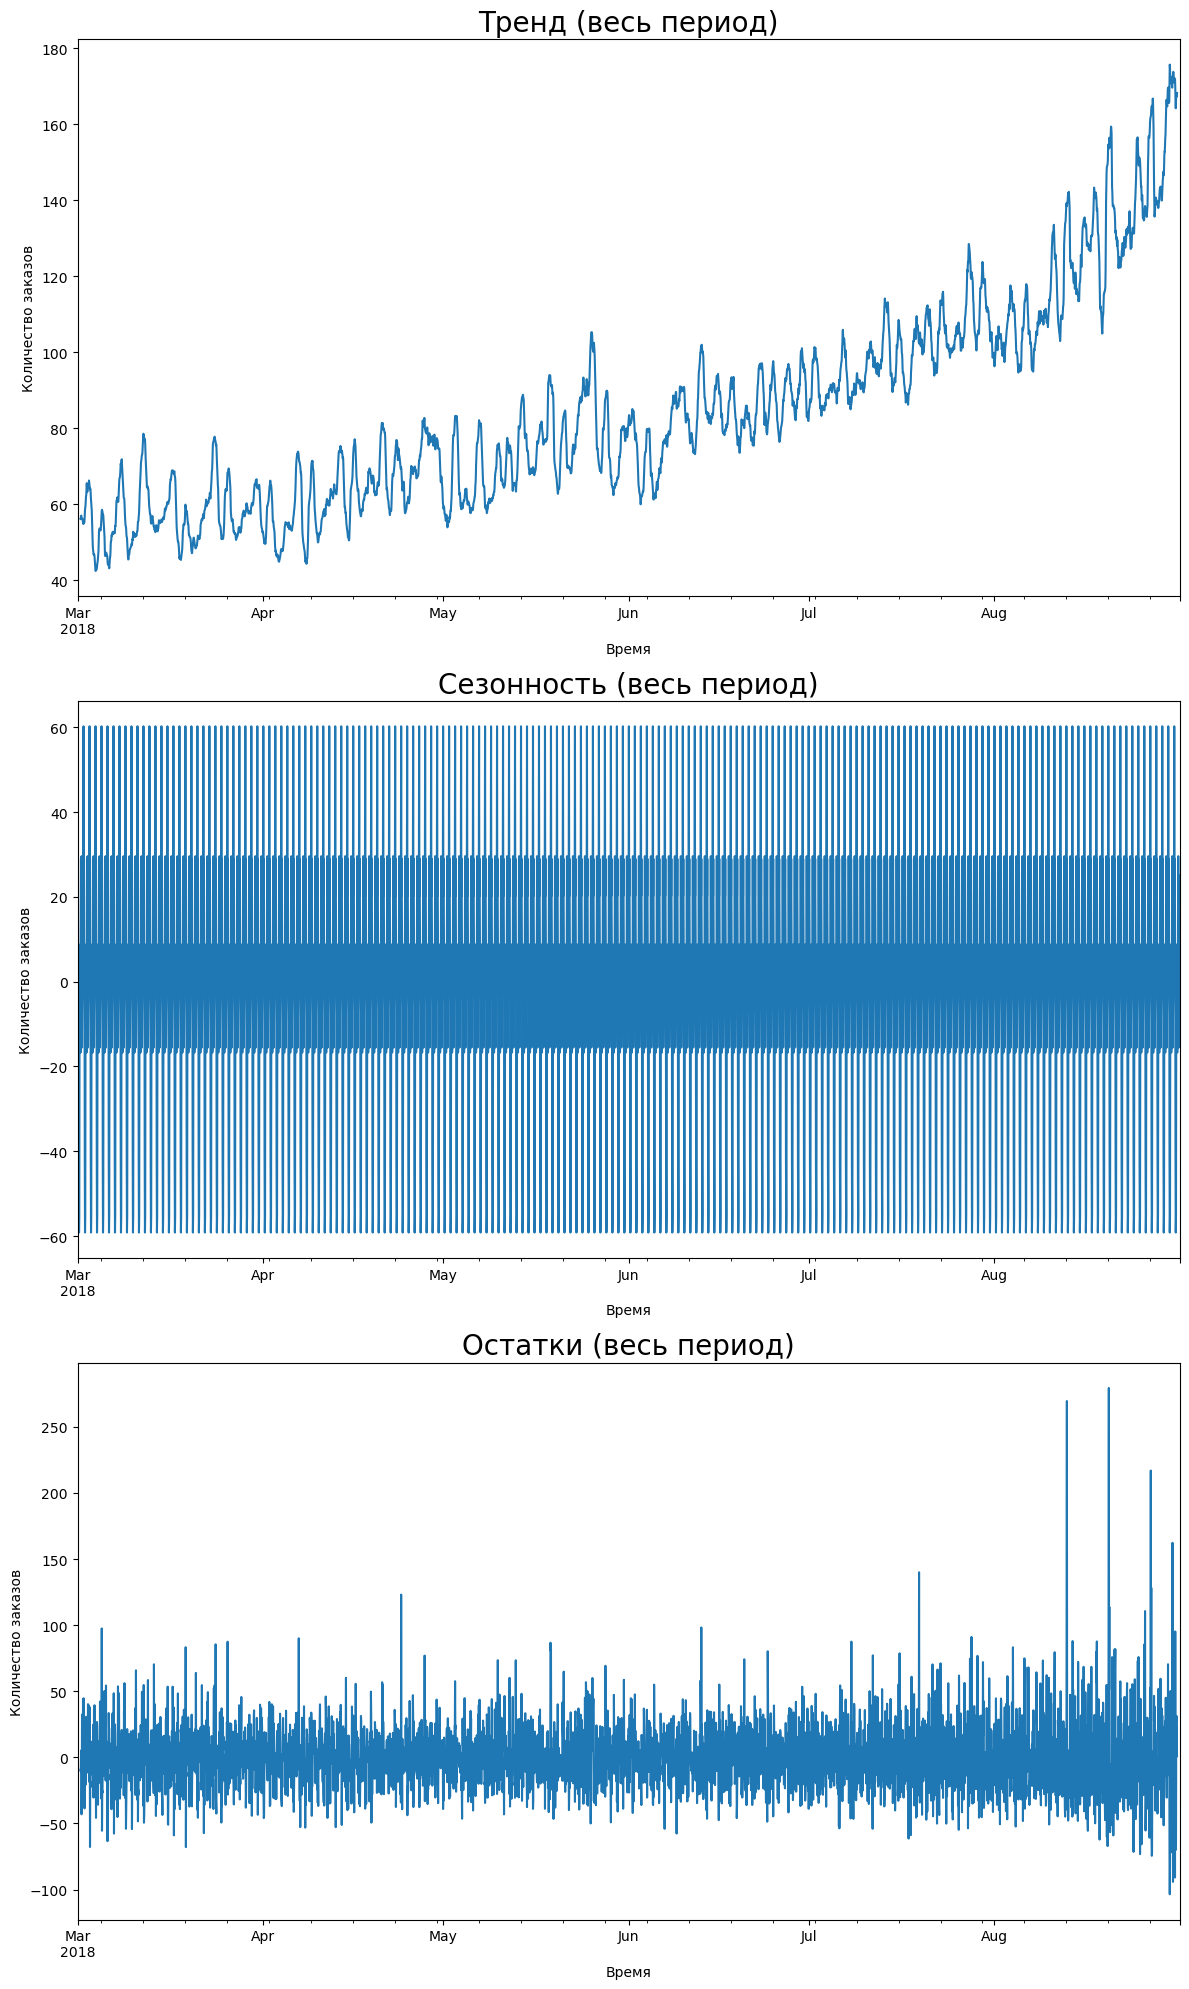

In [10]:
data_dec = seasonal_decompose(data)

plt.figure(figsize=(12, 20))

plt.subplot(311)
data_dec.trend.plot(ax=plt.gca())
plt.ylabel('Количество заказов', size=10)
plt.xlabel('Время', size=10)
plt.title('Тренд (весь период)', size=20)

plt.subplot(312)
data_dec.seasonal.plot(ax=plt.gca())
plt.ylabel('Количество заказов', size=10)
plt.xlabel('Время', size=10)
plt.title('Сезонность (весь период)', size=20)

plt.subplot(313)
data_dec.resid.plot(ax=plt.gca())
plt.ylabel('Количество заказов', size=10)
plt.xlabel('Время', size=10)
plt.title('Остатки (весь период)', size=20)
plt.tight_layout()

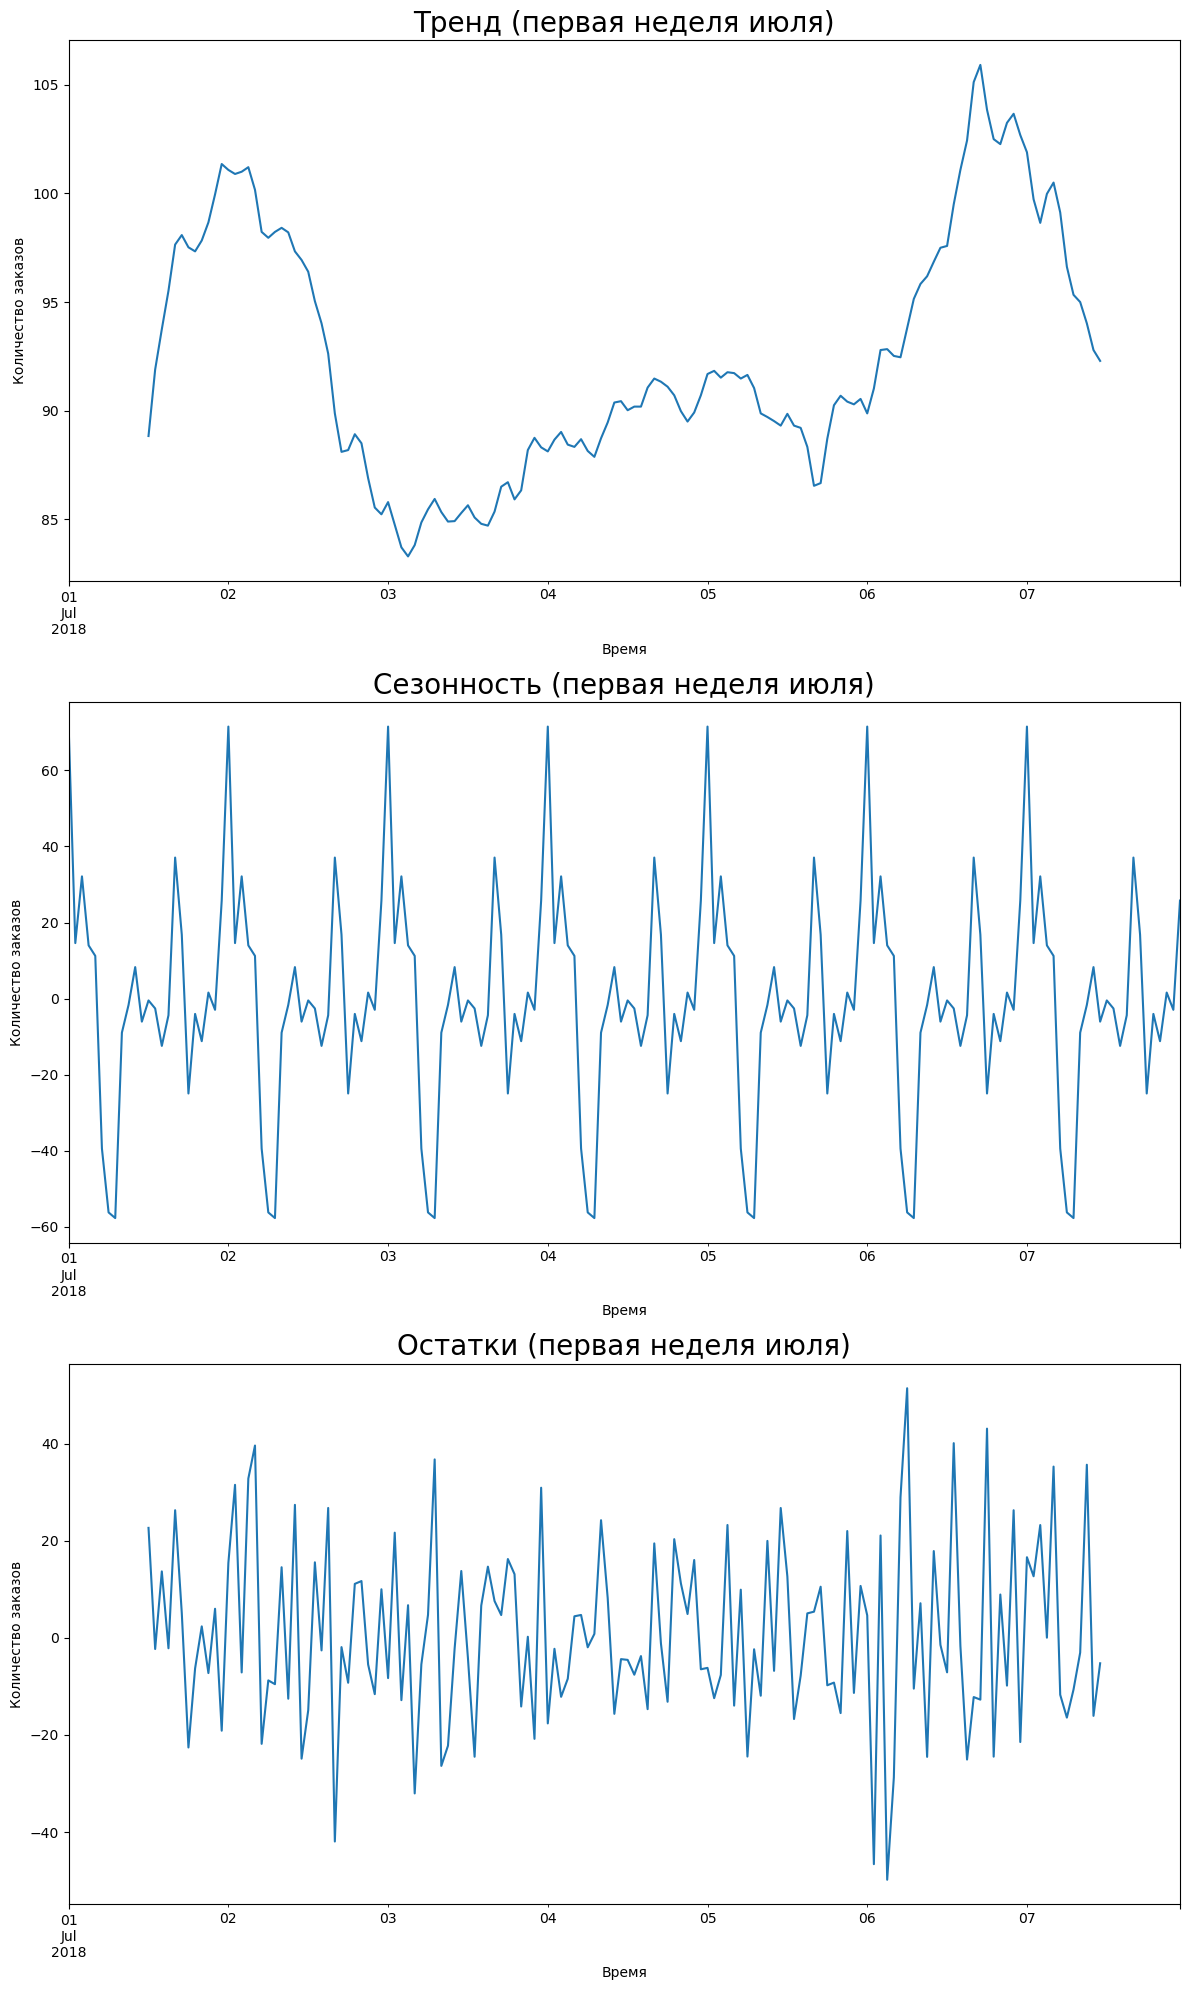

In [11]:
data_dec = seasonal_decompose(data['2018-07-01':'2018-07-07'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
data_dec.trend.plot(ax=plt.gca())
plt.ylabel('Количество заказов', size=10)
plt.xlabel('Время', size=10)
plt.title('Тренд (первая неделя июля)', size=20)

plt.subplot(312)
data_dec.seasonal.plot(ax=plt.gca())
plt.ylabel('Количество заказов', size=10)
plt.xlabel('Время', size=10)
plt.title('Сезонность (первая неделя июля)', size=20)

plt.subplot(313)
data_dec.resid.plot(ax=plt.gca())
plt.ylabel('Количество заказов', size=10)
plt.xlabel('Время', size=10)
plt.title('Остатки (первая неделя июля)', size=20)
plt.tight_layout()

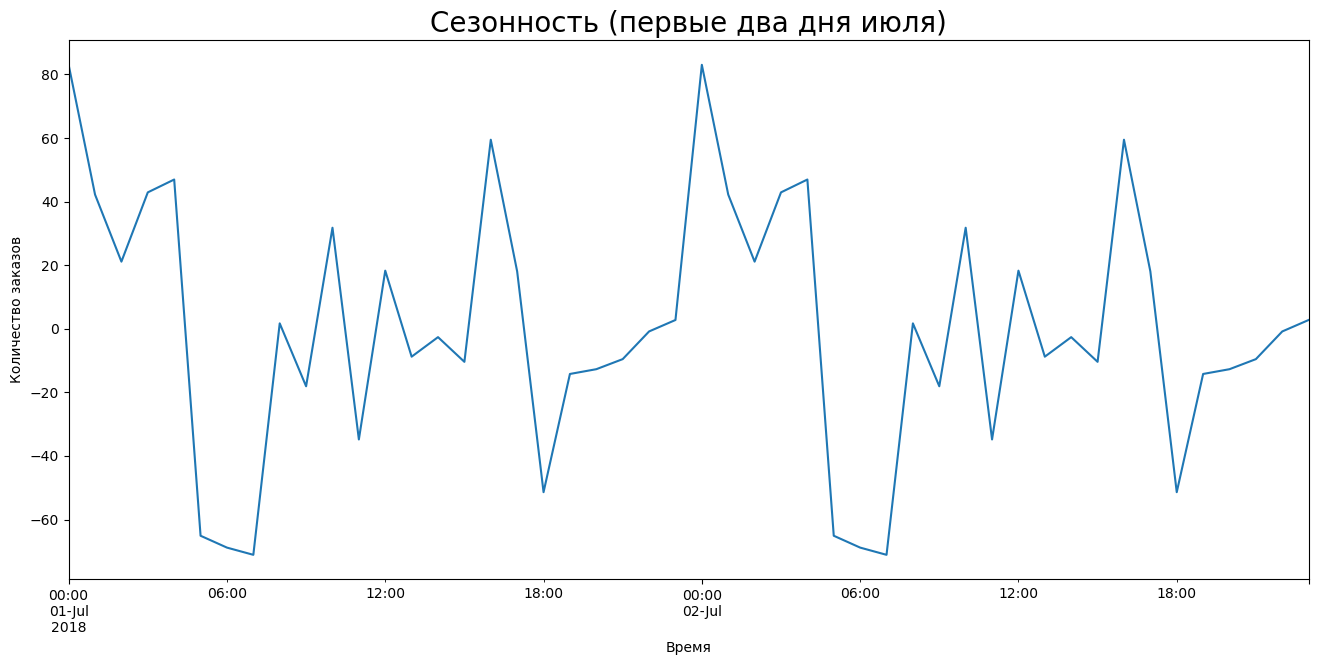

In [12]:
data_dec_2 = seasonal_decompose(data['2018-07-01':'2018-07-02'])

plt.figure(figsize=(16, 7))
data_dec_2.seasonal.plot(ax=plt.gca())
plt.ylabel('Количество заказов', size=10)
plt.xlabel('Время', size=10)
plt.title('Сезонность (первые два дня июля)', size=20)
plt.show()

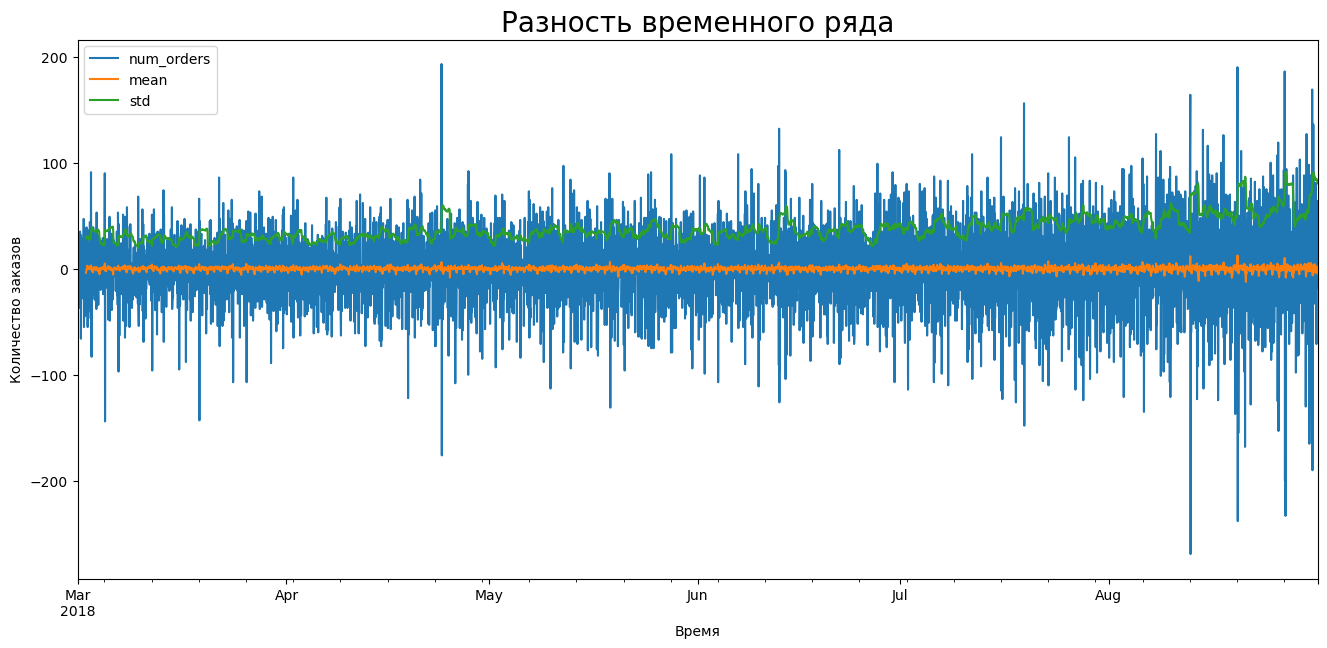

In [13]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(30).mean()
data_shift['std'] = data_shift['num_orders'].rolling(30).std()

plt.figure(figsize=(16, 7))
data_shift.plot(ax=plt.gca())
plt.ylabel('Количество заказов', size=10)
plt.xlabel('Время', size=10)
plt.title('Разность временного ряда', size=20)
plt.show()

Проведем тест Дики-Фуллера на стационарность ряда:

- *Нулевая гипотеза:* временной ряд является нестационарным.
- *Альтернативная гипотеза:* временной ряд является стационарным.

In [14]:
result = adfuller(data['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % result[0])
print('P-значение: %f' % result[1])
print('Критические значения:')
p_value = result[1]

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

alpha = .05
print()
print('При уровне значимости 5%:')
if p_value < alpha:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен.")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд нестационарен.")

alpha = .01
print()
print('При уровне значимости 1%:')
if p_value < alpha:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен.")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд нестационарен.")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567

При уровне значимости 5%:
Нулевая гипотеза отвергнута – Временной ряд стационарен.

При уровне значимости 1%:
Нулевая гипотеза не отвергнута – Временной ряд нестационарен.


**Вывод:**
1. Наблюдается тренд на увеличение количества заказов на данном периоде времени. В общем, тренд начал быстрее расти в летний период времени (с июня до конца августа). В тренде на неделю заметны возросший строс 2, 7 числа. Эти даты совпадают с понедельником и субботой. Возможно, в выходные и после воскресенья такси пользуются большим спросом в аэропортах.
2. Присутствует суточная сезонность с пиками заказов около 12 часов ночи, также пики наблюдаются в часы пик (в 9-10 утра и 5 вечера). Резкий спад идет к раннему утру (около 5-7 утра) и после часа пик в 6 вечера. Природу сезонности можно объяснить тем, что каждый день запросы людей в аэропортах примерно одинаковы. Когда они прилетают поздно вечером и не ходит общественный транспорт, спрос на такси находится в пике. 
3. По сглаживанию скользящим средним, можно предположить, что ряд нестационарен, так как оно увеличивается со временем. Также это подтверждает тест Дики-Фуллера с уровнем значимости 1% (нулевая гипотеза не отвергнута – временной ряд нестационарен). Однако, с уровнем значимости 5% он дает другой результат - временной ряд стационарен. Но скорее всего взят слишком большой уровень значимости. И судя по скользящему среднему будем считать, что ряд нестационарен.
4. При разности временного ряда, он стал более стационарным, скользящее стандартное отклонение также не имеет аномалий.

In [15]:
def make_features(df, max_lag, rolling_sum_size):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_sum'] = df['num_orders'].shift().rolling(rolling_sum_size).mean()
    return df

In [16]:
make_features(data, 24, 50)

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_sum
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,169.64
2018-08-31 20:00:00,154,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,169.18
2018-08-31 21:00:00,159,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,169.86


In [17]:
data = data.dropna()
print(data.head())
print()
print(data.shape)

                     num_orders  day  dayofweek  hour  lag_1  lag_2  lag_3  \
datetime                                                                     
2018-03-03 02:00:00          25    3          5     2  108.0  163.0   72.0   
2018-03-03 03:00:00          64    3          5     3   25.0  108.0  163.0   
2018-03-03 04:00:00          44    3          5     4   64.0   25.0  108.0   
2018-03-03 05:00:00          15    3          5     5   44.0   64.0   25.0   
2018-03-03 06:00:00           9    3          5     6   15.0   44.0   64.0   

                     lag_4  lag_5  lag_6  ...  lag_16  lag_17  lag_18  lag_19  \
datetime                                  ...                                   
2018-03-03 02:00:00  119.0  101.0   93.0  ...    54.0    45.0    46.0     7.0   
2018-03-03 03:00:00   72.0  119.0  101.0  ...    91.0    54.0    45.0    46.0   
2018-03-03 04:00:00  163.0   72.0  119.0  ...    36.0    91.0    54.0    45.0   
2018-03-03 05:00:00  108.0  163.0   72.0  ...   

**Вывод:**
- Дисперсия увеличичвается;
- Тренд в общем растет, следовательно количесто заказов и пользователей растет
- Можно увидеть, что ночью спрос на заказ машины минимальный, тогда как поздно вечером достигает своего пика, также рано вечером (после рабочего дня) есть большой спрос;
- Временной ряд не является стационарным, так как подвержен тренду, который меняется во времени;
- Написана функция для добавления признаков для будущего обучения модели, где выделены: год, день, день недели, час, отстающие значения и скользящее среднее со смещением.

## Обучение

In [18]:
data_train, data_test = train_test_split(data, shuffle=False, test_size=0.1, random_state=12345) 

features_train = data_train.drop(['num_orders'], axis=1)
target_train = data_train['num_orders']
features_test = data_test.drop('num_orders', axis=1)
target_test = data_test['num_orders']

print(f'Размерность признаков - {features_train.shape} и целевого признака - {target_train.shape} обучающей выборки')
print(f'Размерность признаков - {features_test.shape} и целевого признака - {target_test.shape} тестовой выборки')

Размерность признаков - (3929, 28) и целевого признака - (3929,) обучающей выборки
Размерность признаков - (437, 28) и целевого признака - (437,) тестовой выборки


### LGBM

In [19]:
%%time
lgbmmodel = LGBMRegressor(random_state = 12345) 
param = {'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5]}
CV = TimeSeriesSplit(n_splits=3).split(features_train)
gscv_lgbm = GridSearchCV(lgbmmodel, param, cv=CV, scoring='neg_mean_squared_error')
gscv_lgbm.fit(features_train, target_train)
print(gscv_lgbm.best_params_)

{'learning_rate': 0.1, 'num_leaves': 25}
Wall time: 8.45 s


### XGBoost

In [20]:
%%time
xgbmodel = XGBRegressor(random_state = 12345)
param = {'max_depth':[3, 5, 7], 'learning_rate':[.1, .3, .5], 'n_estimators':[400, 500]}
CV = TimeSeriesSplit(n_splits=3).split(features_train)
gscv_xgb = GridSearchCV(xgbmodel, param, cv=CV, scoring='neg_mean_squared_error')
gscv_xgb.fit(features_train, target_train)
print(gscv_xgb.best_params_)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400}
Wall time: 51.1 s


### DecisionTree

In [21]:
%%time
trmodel = DecisionTreeRegressor(random_state = 12345) 
param = {'max_depth':[None] + [i for i in range(2, 7)], 'criterion':['mse']}
CV = TimeSeriesSplit(n_splits=3).split(features_train)
gscv_tree = GridSearchCV(trmodel, param, cv=CV, scoring='neg_mean_squared_error')
gscv_tree.fit(features_train, target_train)
print(gscv_tree.best_params_)

{'criterion': 'mse', 'max_depth': 5}
Wall time: 489 ms


### CatBoost

In [22]:
%%time
catmodel = CatBoostRegressor(loss_function='RMSE', random_state = 12345)
param = {'depth':[5, 10], 'learning_rate':np.arange(0.1, 1, 0.2)}
CV = TimeSeriesSplit(n_splits=3).split(features_train)
gscv_cat = GridSearchCV(catmodel, param, cv=CV, scoring='neg_mean_squared_error')
gscv_cat.fit(features_train, target_train)

0:	learn: 27.9351232	total: 159ms	remaining: 2m 38s
1:	learn: 26.8715051	total: 161ms	remaining: 1m 20s
2:	learn: 25.9024789	total: 163ms	remaining: 54.2s
3:	learn: 25.0201808	total: 165ms	remaining: 41.1s
4:	learn: 24.1947994	total: 167ms	remaining: 33.3s
5:	learn: 23.4867498	total: 169ms	remaining: 28s
6:	learn: 23.0354004	total: 171ms	remaining: 24.2s
7:	learn: 22.4606801	total: 173ms	remaining: 21.4s
8:	learn: 21.9772565	total: 175ms	remaining: 19.3s
9:	learn: 21.6102284	total: 177ms	remaining: 17.5s
10:	learn: 21.1880756	total: 179ms	remaining: 16.1s
11:	learn: 20.7569524	total: 181ms	remaining: 14.9s
12:	learn: 20.3755109	total: 183ms	remaining: 13.9s
13:	learn: 20.0439770	total: 185ms	remaining: 13s
14:	learn: 19.7592961	total: 187ms	remaining: 12.3s
15:	learn: 19.5071314	total: 189ms	remaining: 11.6s
16:	learn: 19.2747291	total: 191ms	remaining: 11s
17:	learn: 19.0439925	total: 193ms	remaining: 10.5s
18:	learn: 18.8653012	total: 195ms	remaining: 10s
19:	learn: 18.7328980	total:

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000140E1C022E0>,
             estimator=<catboost.core.CatBoostRegressor object at 0x00000140E194E3A0>,
             param_grid={'depth': [5, 10],
                         'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9])},
             scoring='neg_mean_squared_error')

In [23]:
gscv_cat.best_params_

{'depth': 5, 'learning_rate': 0.1}

In [24]:
df = [[(gscv_tree.best_score_*-1)**0.5],
      [(gscv_cat.best_score_*-1)**0.5],
      [(gscv_lgbm.best_score_*-1)**0.5], 
      [(gscv_xgb.best_score_*-1)**0.5]]
model = ["DecisionTree", "CatBoost", "LGBM", "XGBoost"]
pd.DataFrame(data=df, index=model, columns=["Оценка по кросс-валидации"])

,Оценка по кросс-валидации
DecisionTree,31.222481
CatBoost,26.575171
LGBM,27.052495
XGBoost,26.821901


**Вывод:**
- Данные разделены на тренировочную и тестовую выборки в отношении 9:1;
- Подобраны лучшие параметры на 4 моделях.

1. Среди моделей с хорошей оценкой можно выделить - LGBM, CatBoost и XGBoost. (Оценка в среднем ~ 26.8).
2. Хуже всего себя показала модель DecisionTree, ее оценка составляет 31.22. Ее точно не стоит рассматривать как финальную.

Выбираем **CatBoost**, так как среди всех моделей она показала лучшую оценку = 26.58.

## Тестирование

### Проверка на адекватность

#### Предсказание константного значения = 150

In [25]:
dummy_regr = DummyRegressor(strategy="constant", constant=150)
dummy_regr.fit(features_train, target_train)

mse_dummy = mean_squared_error(target_test, dummy_regr.predict(features_test))
print("RMSE для DummyRegressor:", (mse_dummy) ** 0.5)

RMSE для DummyRegressor: 59.71563046421875


#### Предсказание среднего значения тренировочной выборки

In [26]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)

mse_dummy = mean_squared_error(target_test, dummy_regr.predict(features_test))
print("RMSE для DummyRegressor:", (mse_dummy) ** 0.5)

RMSE для DummyRegressor: 84.7599140370457


### CatBoost

In [27]:
%%time
catmodel = CatBoostRegressor(learning_rate=.1, depth=5, random_state=12345)
catmodel.fit(features_train, target_train)

0:	learn: 36.8351736	total: 3.87ms	remaining: 3.87s
1:	learn: 35.3389300	total: 7.3ms	remaining: 3.64s
2:	learn: 34.0420281	total: 10.7ms	remaining: 3.57s
3:	learn: 32.8569976	total: 14.7ms	remaining: 3.67s
4:	learn: 31.6774956	total: 18.4ms	remaining: 3.65s
5:	learn: 30.7471419	total: 22.1ms	remaining: 3.66s
6:	learn: 30.0042849	total: 26.1ms	remaining: 3.69s
7:	learn: 29.3079630	total: 29.9ms	remaining: 3.7s
8:	learn: 28.6136627	total: 33.7ms	remaining: 3.71s
9:	learn: 28.0198090	total: 37.4ms	remaining: 3.71s
10:	learn: 27.5308085	total: 41.5ms	remaining: 3.73s
11:	learn: 27.1289275	total: 46.2ms	remaining: 3.8s
12:	learn: 26.6898071	total: 50.3ms	remaining: 3.82s
13:	learn: 26.3349240	total: 54.5ms	remaining: 3.84s
14:	learn: 26.0329261	total: 57.9ms	remaining: 3.8s
15:	learn: 25.7833554	total: 61.1ms	remaining: 3.76s
16:	learn: 25.5268829	total: 64.6ms	remaining: 3.73s
17:	learn: 25.3417274	total: 68.9ms	remaining: 3.76s
18:	learn: 25.1142204	total: 72.4ms	remaining: 3.74s
19:	lea

In [28]:
%%time
cat_predict = catmodel.predict(features_test)

Wall time: 3.23 ms


In [29]:
mse_catmodel = mean_squared_error(target_test, cat_predict)
print("RMSE для CatBoost:", (mse_catmodel) ** 0.5)

RMSE для CatBoost: 41.42884657771448


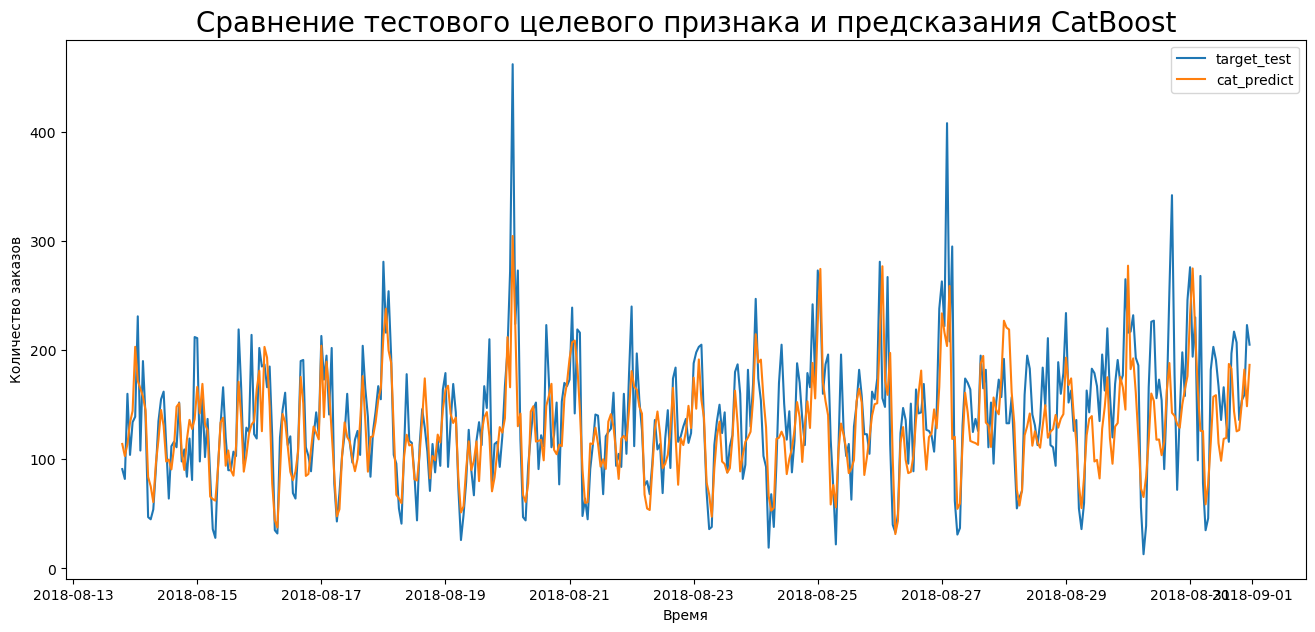

In [30]:
plt.figure(figsize=(16, 7))
plt.plot(target_test.index, target_test, target_test.index, cat_predict)
plt.legend(['target_test', 'cat_predict'])
plt.ylabel('Количество заказов', size=10)
plt.xlabel('Время', size=10)
plt.title('Сравнение тестового целевого признака и предсказания CatBoost', size=20)
plt.show()

## Вывод

Во время проекты были загружены данные и выполнено их ресемплирование по одному часу. Они были проанализированы. Обучены разные модели с различными гиперпараметрами. Проверена лучшая модель на тестовой выборке.

- Данные загружены с индексом времени и отсортированы по данному индексу, пропущенных значений не было.
- Наблюдается тренд на увеличение количества заказов на данном периоде времени. 
- Присутствует суточная сезонность с пиками заказов около 12 часов ночи, также пики наблюдаются в часы пик (в 9-10 утра и 5 вечера). Резкий спад идет к раннему утру (около 5-7 утра) и после часа пик в 6 вечера.
- По сглаживанию скользящим средним, можно предположить, что ряд нестационарен, так как оно увеличивается со временем. Также это подтверждает тест Дики-Фуллера с уровнем значимости 1% (нулевая гипотеза не отвергнута – временной ряд нестационарен). 
- Написана функция для добавления признаков для будущего обучения модели, где выделены: год, день, день недели, час, отстающие значения и скользящее среднее со смещением.

1. Хорошо себя показали модели LGBM (с оценкой на кросс-валидации = 27.05 и гипермараметрами *depth=25* и *learning_rate = 0.1*) и XGBoost (с оценкой на кросс-валидации = 26.82 и гипермараметрами *max_depth = 3*, *learning_rate = 0.1* и *n_estimators = 400*). 
2. DecisionTree	показал наихудший результат на кросс-валидации = 31.22.
3. Лучше всего с оценкой на кросс-валидации = 26.58 показала модель CatBoost.


Лучшей моделью стала **CatBoost.** с RMSE равной 41.43 и параметрами *depth=25* и *learning_rate = 0.1*. Проверку на адекватность модель также прошла успешно (по предсказаниям по среднему значения тренировочной выборки RMSE = 84.76, а по константе = 150, RMSE = 59.72). В среднем модель хорошо показывает себя по сравнению с фактическими значениями, наблюдатаются отклонения в значениях в пиковых моментах. Когда сильных отклонений нет - предсказания больше совпадают с фактическими.